# False Positive Brand Classifier - EDA & Feature Engineering

This notebook focuses on exploratory data analysis and feature engineering for the FP classifier. It compares multiple feature engineering approaches and exports the best transformer for use in model selection.

## Objective
Develop feature engineering pipeline that can distinguish between articles that genuinely mention sportswear brands vs false positives (e.g., "Puma" the animal, "Patagonia" the region).

**Key Insight: This is a recall-focused problem.**
- **Missing a real sportswear article (low recall) = BAD** - we lose the article forever
- **Letting through a false positive (low precision) = OK** - LLM can catch it later

We optimize for **F2 score** which weights recall 2x higher than precision.

## Contents
1. [Setup](#setup)
2. [Data Loading](#1-data-loading)
3. [Target Variable Analysis](#2-target-variable-analysis) (ALL DATA - for stratification)
4. [Data Preprocessing & Split](#3-data-preprocessing--split)
5. [Exploratory Data Analysis](#4-exploratory-data-analysis) (TRAINING DATA ONLY)
6. [Feature Engineering Comparison](#5-feature-engineering-comparison)
   - 5.1 [Feature Transformer Hyperparameter Tuning](#51-feature-transformer-hyperparameter-tuning)
7. [Pipeline Export](#6-pipeline-export)
8. [Summary](#7-summary)

## Setup

In [1]:
# Standard imports
import json
import sys
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse

# Sklearn imports
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_validate

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Project imports
from src.fp1_nb.data_utils import (
    load_jsonl_data,
    analyze_target_stats,
    split_train_val_test,
)
from src.fp1_nb.eda_utils import (
    analyze_text_length_stats,
    plot_text_length_distributions,
    analyze_brand_distribution,
    plot_brand_distribution,
    analyze_word_frequencies,
)
from src.fp1_nb.preprocessing import (
    clean_text,
    create_text_features,
    SPORTSWEAR_VOCAB,
)
from src.fp1_nb.feature_transformer import FPFeatureTransformer

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')

# Configuration
TARGET_COL = 'is_sportswear'
LABEL_NAMES = ['Not Sportswear (FP)', 'Sportswear']
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.6, 0.2, 0.2
RANDOM_STATE = 42
N_FOLDS = 3

# Paths
DATA_PATH = project_root / 'data' / 'fp_training_data.jsonl'
MODELS_DIR = project_root / 'models'
IMAGES_DIR = project_root / 'images'

# Create directories
MODELS_DIR.mkdir(exist_ok=True)
IMAGES_DIR.mkdir(exist_ok=True)

np.random.seed(RANDOM_STATE)

print("Setup complete!")

Setup complete!


## 1. Data Loading

In [2]:
# Load the FP training data
DATA_PATH = project_root / 'data' / 'fp_training_data.jsonl'
df = load_jsonl_data(DATA_PATH)

Loaded 1,018 records from fp_training_data.jsonl
Columns: ['article_id', 'title', 'content', 'brands', 'source_name', 'category', 'is_sportswear', 'source', 'fp_reason']
Memory usage: 7.35 MB


In [3]:
# Preview the data
df.head()

,article_id,title,content,brands,source_name,category,is_sportswear,source,fp_reason
0,4c227d4f-e315-4ff6-bc91-fef52fd8e732,MM6 Maison Margiela x Salomon XT - MM6 & ACS Pro Fall 2025 Release Date,"Ever since their debut collaboration in 2022 featuring the Rihanna-approved Cross Low model, MM6...",[Salomon],wwd.com,[],1,skipped,NaN
1,62df09ce-8fd1-4139-998a-5e94cfe924ef,The factors behind Lululemon CEO Calvin McDonald departure from the brand,"After seven years as CEO of athleisure giant Lululemon, retail veteran Calvin McDonald announced...",[Lululemon],insideretail.asia,[],1,labeled,NaN
2,485e193a-3f30-4f1c-855e-a947681b2cbf,Tracy McGrady Says Kobe Leaving Adidas Helped Him Get a Bigger Deal | The Complex Sneakers Podcast,"Complex's\n\nThe Complex Sneakers Show\n\nSeason 17\n\nDecember 12, 2025\n\nTracy McGrady Says K...",[Adidas],complex.com,[],1,skipped,NaN
3,10e8ecbc-0625-4aaa-b5f4-e0f4ae02527c,Where to buy Nike Air Force 1 07 Mid Flax sneakers releasing Oct . 8,"Your favorite Nike street style shoes are getting a refresh that’ll add a crisp, neutral look to...",[Nike],mlive.com,[],1,skipped,NaN
4,04a3817e-38c5-4b62-a678-6eaf49a458c5,"Prime Day competitor sales : The best deals from Walmart , Wayfair , Lululemon and other Amazon ...","As a participant in multiple affiliate marketing programs, Localish will earn a commission for c...",[Lululemon],abc7news.com,[],1,skipped,NaN


In [4]:
# Data types and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   article_id     1018 non-null   object
 1   title          1018 non-null   object
 2   content        1018 non-null   object
 3   brands         1018 non-null   object
 4   source_name    1018 non-null   object
 5   category       1018 non-null   object
 6   is_sportswear  1018 non-null   int64 
 7   source         1018 non-null   object
 8   fp_reason      158 non-null    object
dtypes: int64(1), object(8)
memory usage: 71.7+ KB


In [5]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
article_id         0
title              0
content            0
brands             0
source_name        0
category           0
is_sportswear      0
source             0
fp_reason        860
dtype: int64


In [6]:
# Examine the source distribution
print("\nSource distribution:")
print(df['source'].value_counts())


Source distribution:
source
labeled           629
skipped           231
false_positive    158
Name: count, dtype: int64


## 2. Target Variable Analysis (ALL DATA)

This analysis uses the full dataset to understand class imbalance before splitting. This is necessary to inform our stratification strategy.

TARGET VARIABLE ANALYSIS

Total samples: 1,018

Class distribution:
  Not Sportswear (FP): 158 (15.5%)
  Sportswear: 860 (84.5%)

Imbalance ratio: 5.44:1

[WARNING] Dataset is imbalanced (ratio >= 5.0)
Consider using:
  - Stratified sampling for train/val/test splits
  - Class weights or oversampling/undersampling
  - Appropriate metrics (PR-AUC, F1) over accuracy


Figure saved to images/fp_target_distribution.png


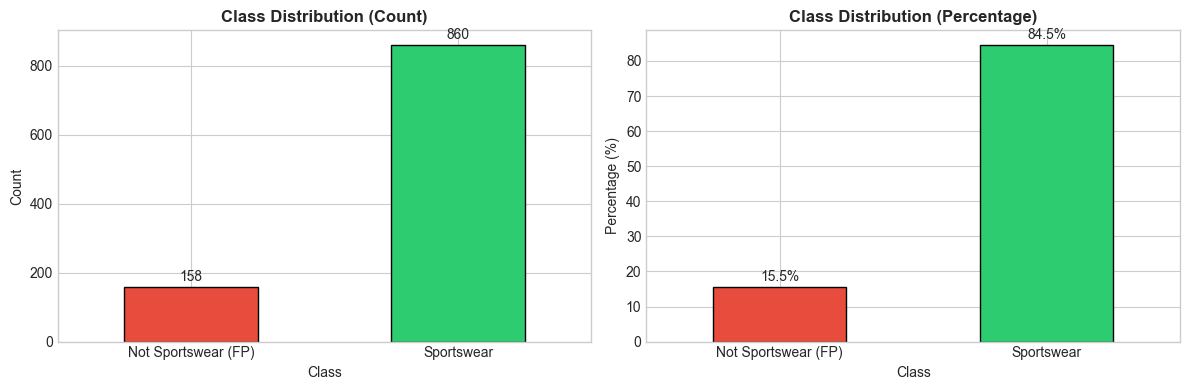

In [7]:
# Analyze target distribution
target_stats = analyze_target_stats(
    df, 
    TARGET_COL, 
    label_names=LABEL_NAMES,
    imbalance_threshold=5.0,
    save_path='images/fp_target_distribution.png'
)

## 3. Data Preprocessing & Train/Val/Test Split

We preprocess the text data first (creating text_features), then split into train/val/test sets. All subsequent EDA and feature engineering will use ONLY the training data to prevent data leakage. The validation dataset is used for feature engineering selection. The test data set is NOT used in this notebook.

In [8]:
# Create text features BEFORE splitting
# This combines title, brands, content, and metadata (source, category) into a single cleaned text field
df['text_features'] = create_text_features(
    df,
    text_col='content',
    title_col='title',
    brands_col='brands',
    source_name_col='source_name',
    category_col='category',
    include_metadata=True,
    clean_func=clean_text
)

print("Text features created!")
print(f"Sample:\n{df['text_features'].iloc[0][:300]}...")

# Check for empty text features
empty_texts = (df['text_features'].str.len() == 0).sum()
print(f"\nRecords with empty text features: {empty_texts}")
if empty_texts > 0:
    df = df[df['text_features'].str.len() > 0].copy()
    print(f"Remaining records after removing empty: {len(df)}")

Text features created!
Sample:
wwd.com mm6 maison margiela salomon xt mm6 acs pro fall 2025 release date mm6 maison margiela salomon xt mm6 acs pro fall 2025 release date salomon ever since their debut collaboration in 2022 featuring the rihanna approved cross low model mm6 maison margiela and salomon have been frequent partners ...

Records with empty text features: 0


In [9]:
# Split with stratification
train_df, val_df, _ = split_train_val_test(
    df,
    target_col=TARGET_COL,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    random_state=RANDOM_STATE
)

# Extract features and targets
X_train = train_df['text_features']
y_train = train_df[TARGET_COL]

X_val = val_df['text_features']
y_val = val_df[TARGET_COL]

# Extract metadata for discrete metadata features
train_source_names = train_df['source_name'].tolist()
train_categories = train_df['category'].tolist()
val_source_names = val_df['source_name'].tolist()
val_categories = val_df['category'].tolist()

print(f"\nDataset sizes:")
print(f"  Train: {len(X_train)} samples")
print(f"  Val:   {len(X_val)} samples")

TRAIN/VALIDATION/TEST SPLIT

Total samples: 1,018

Split ratios: 60% / 20% / 20%

Resulting sizes:
  Train:      610 (59.9%)
  Validation: 204 (20.0%)
  Test:       204 (20.0%)

Class distribution (stratified by 'is_sportswear'):
  Train: 1: 84.6%, 0: 15.4%
  Val: 1: 84.3%, 0: 15.7%
  Test: 1: 84.3%, 0: 15.7%

Dataset sizes:
  Train: 610 samples
  Val:   204 samples


## 4. Exploratory Data Analysis (TRAINING DATA ONLY)

All EDA from this point forward uses ONLY the training data to prevent data leakage.

### 4.1 Text Length Analysis

In [10]:
# Analyze text lengths (TRAINING DATA ONLY)
text_stats = analyze_text_length_stats(train_df, 'content', TARGET_COL)

TEXT LENGTH STATISTICS

Column: 'content'
Total records: 610

Overall statistics:
  Character length: mean=3748, median=2548, range=[140, 52711]
  Word count: mean=608, median=406, range=[22, 8910]

By is_sportswear:
  Class 1:
    Chars: mean=3507, median=2490
    Words: mean=569, median=391
  Class 0:
    Chars: mean=5070, median=2912
    Words: mean=817, median=468


Figure saved to images/fp_text_length_dist.png


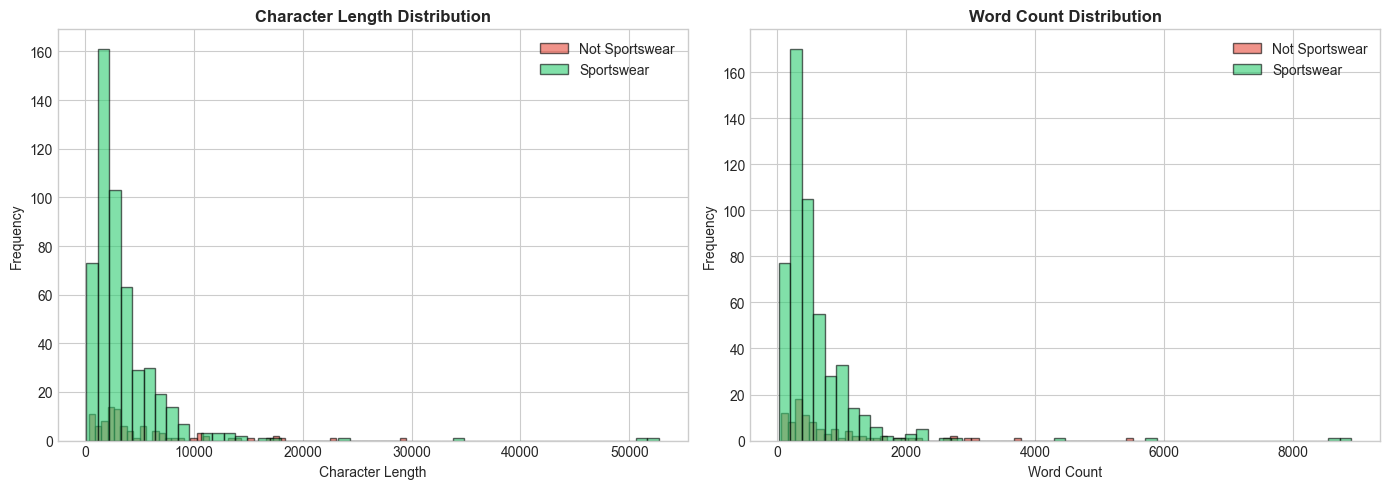

In [11]:
# Plot text length distributions by class (TRAINING DATA ONLY)
plot_text_length_distributions(
    train_df, 'content', TARGET_COL,
    label_names={0: 'Not Sportswear', 1: 'Sportswear'},
    save_path='images/fp_text_length_dist.png'
)

### 4.2 Brand Distribution

In [12]:
# Analyze brand distribution (TRAINING DATA ONLY)
brand_counts = analyze_brand_distribution(train_df, 'brands', TARGET_COL, top_n=15)

BRAND DISTRIBUTION

Total brand mentions: 648
Unique brands: 41

Top 15 brands:
  Nike: 156 (24.1%)
  Lululemon: 76 (11.7%)
  Adidas: 38 (5.9%)
  Hoka: 31 (4.8%)
  Puma: 29 (4.5%)
  Vans: 29 (4.5%)
  Anta: 28 (4.3%)
  Skechers: 25 (3.9%)
  Patagonia: 24 (3.7%)
  New Balance: 20 (3.1%)
  Black Diamond: 20 (3.1%)
  Reebok: 20 (3.1%)
  Timberland: 17 (2.6%)
  Converse: 14 (2.2%)
  Salomon: 13 (2.0%)

Brand distribution by is_sportswear:
  Class 0: 96 mentions, top: Black Diamond (19), Anta (17), Vans (14)
  Class 1: 552 mentions, top: Nike (155), Lululemon (76), Adidas (38)


Figure saved to images/fp_brand_dist.png


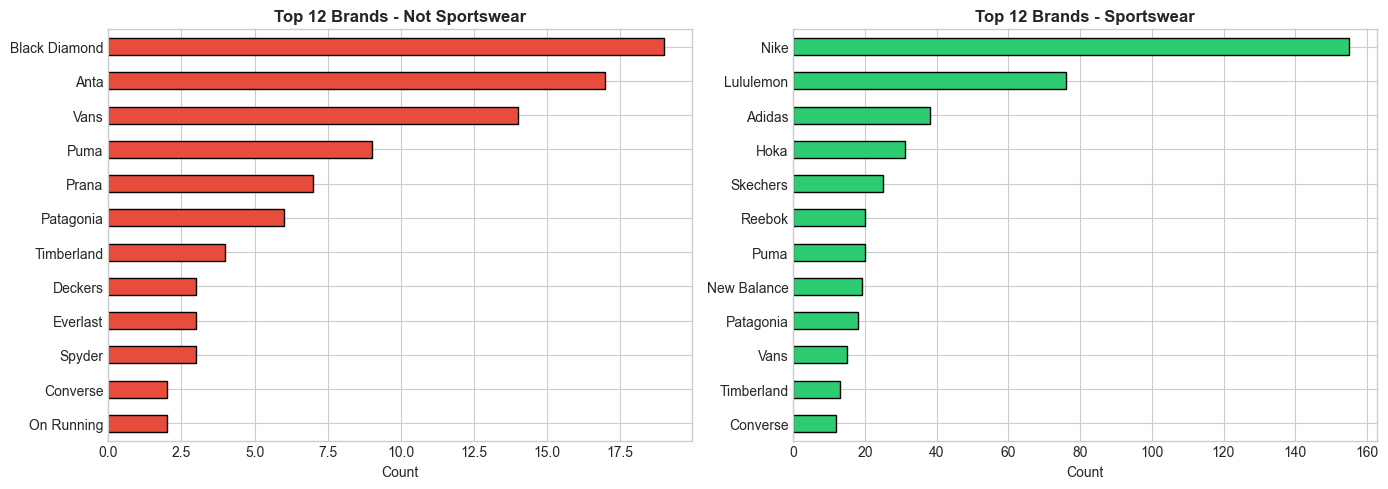

In [13]:
# Plot brand distribution by class (TRAINING DATA ONLY)
plot_brand_distribution(
    train_df, 'brands', TARGET_COL,
    label_names={0: 'Not Sportswear', 1: 'Sportswear'},
    top_n=12,
    figsize=(14, 5),
    save_path='images/fp_brand_dist.png'
)

### 4.3 Word Frequency Analysis

In [14]:
# Analyze word frequencies by class (TRAINING DATA ONLY)
word_freqs = analyze_word_frequencies(train_df, 'content', TARGET_COL, top_n=15)

WORD FREQUENCY ANALYSIS

Top 15 words for class_0:
  company: 189
  out: 130
  over: 127
  year: 119
  time: 108
  like: 108
  black: 106
  diamond: 103
  get: 95
  looking: 89
  across: 89
  group: 86
  curtains: 86
  well: 85
  pvc: 85

Top 15 words for class_1:
  nike: 1,391
  company: 942
  year: 824
  lululemon: 726
  brand: 714
  quarter: 584
  stock: 580
  out: 559
  like: 557
  running: 515
  shares: 514
  over: 492
  shoe: 487
  price: 462
  shoes: 401


In [15]:
# Look at some false positive examples (TRAINING DATA ONLY)
print("\n" + "="*60)
print("SAMPLE FALSE POSITIVE ARTICLES (from training data)")
print("="*60)

fp_train = train_df[train_df[TARGET_COL] == 0]
if len(fp_train) >= 3:
    fp_samples = fp_train.sample(3, random_state=RANDOM_STATE)
else:
    fp_samples = fp_train

for _, row in fp_samples.iterrows():
    print(f"\nBrands: {row['brands']}")
    print(f"Title: {row['title'][:100]}...")
    if 'fp_reason' in row and pd.notna(row['fp_reason']):
        print(f"Reason: {row['fp_reason']}")
    print("-" * 40)


SAMPLE FALSE POSITIVE ARTICLES (from training data)

Brands: ['Spyder']
Title: Can - Am Spyder F3 / RT Vs Ryker : How Do These 3 - Wheeled Motorcycles Compare ? ...
Reason: Spyder: Article is about Can-Am Spyder motorcycles/three-wheeled vehicles, not Spyder sportswear/ski apparel
----------------------------------------

Brands: ['Vans']
Title: Rivian recalls electric delivery vans over seat belt issue...
Reason: Vans: Article is about Rivian electric delivery vans (vehicles), not Vans footwear/apparel company
----------------------------------------

Brands: ['Vans']
Title: Best used vans to buy 2025 | Auto Express...
Reason: Vans: Article is about commercial vehicles/vans (Ford Transit Custom, Toyota Proace, etc.), not Vans sportswear/footwear company
----------------------------------------


## 5. Feature Engineering Comparison

We compare multiple feature engineering approaches using cross-validation on the training data with a baseline Logistic Regression classifier. This helps us select the best approach before moving to model selection in the next notebook.

In [16]:
# Define feature engineering approaches to compare
fe_configs = {
    'tfidf_word': {
        'method': 'tfidf_word',
        'max_features': 10000,
        'ngram_range': (1, 2),
        'sublinear_tf': True,
    },
    'tfidf_lsa': {
        'method': 'tfidf_lsa',
        'max_features': 10000,
        'lsa_n_components': 100,
    },
    'doc2vec': {
        'method': 'doc2vec',
        'doc2vec_vector_size': 100,
        'doc2vec_min_count': 2,
        'doc2vec_epochs': 40,
        'doc2vec_dm': 1,
    },
    'sentence_transformer_ner': {
        'method': 'sentence_transformer_ner',
        'sentence_model_name': 'all-MiniLM-L6-v2',
    },
}

# Hyperparameter tuning configurations for each method
# These define which parameter to tune and what values to try
TUNING_CONFIGS = {
    'tfidf_lsa': {
        'param_name': 'lsa_n_components',
        'param_values': [50, 60, 80, 100, 120, 150, 200],
        'description': 'LSA dimensionality'
    },
    'doc2vec': {
        'param_name': 'doc2vec_vector_size',
        'param_values': [50, 60, 80, 100, 120, 150],
        'description': 'Doc2Vec embedding dimension'
    },
    'sentence_transformer_ner': {
        'param_name': 'proximity_window_size',
        'param_values': [10, 15, 20, 25, 30],
        'description': 'NER proximity window size'
    },
    'tfidf_word': {
        'param_name': 'max_features',
        'param_values': [5000, 6000, 8000, 10000, 12000, 15000],
        'description': 'TF-IDF vocabulary size'
    },
}

print("Feature Engineering Approaches to Compare:")
print("=" * 50)
for name, config in fe_configs.items():
    print(f"  {name}: {config['method']}")

print("\nTuning configurations defined for:")
for name in TUNING_CONFIGS:
    cfg = TUNING_CONFIGS[name]
    print(f"  {name}: {cfg['param_name']} = {cfg['param_values']}")

Feature Engineering Approaches to Compare:
  tfidf_word: tfidf_word
  tfidf_lsa: tfidf_lsa
  doc2vec: doc2vec
  sentence_transformer_ner: sentence_transformer_ner

Tuning configurations defined for:
  tfidf_lsa: lsa_n_components = [50, 60, 80, 100, 120, 150, 200]
  doc2vec: doc2vec_vector_size = [50, 60, 80, 100, 120, 150]
  sentence_transformer_ner: proximity_window_size = [10, 15, 20, 25]
  tfidf_word: max_features = [5000, 6000, 8000, 10000, 12000, 15000]


In [17]:
# Evaluate each feature engineering approach using cross-validation
# Compare with Logistic Regression, Random Forest, and HistGradientBoosting classifiers
f2_scorer = make_scorer(fbeta_score, beta=2)
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Define classifiers to benchmark
classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(
            max_iter=2000,
            class_weight=None,
            random_state=RANDOM_STATE,
            solver='lbfgs'
        ),
        'requires_dense': False,  # LR handles sparse matrices
    },
    'RandomForest': {
        'model': RandomForestClassifier(
            n_estimators=100,
            random_state=RANDOM_STATE,
            class_weight='balanced',
            n_jobs=-1
        ),
        'requires_dense': False,  # RF handles sparse matrices
    },
    'HistGradientBoosting': {
        'model': HistGradientBoostingClassifier(
            max_iter=100,
            max_depth=5,
            class_weight=None,
            random_state=RANDOM_STATE,
        ),
        'requires_dense': True,  # HGB requires dense arrays
    },
}

fe_results = []

for name, config in fe_configs.items():
    print(f"Evaluating {name}...")
    
    # Create transformer
    transformer = FPFeatureTransformer(**config, random_state=RANDOM_STATE)
    
    # Fit and transform training data with metadata
    X_train_fe = transformer.fit_transform(
        X_train,
        source_names=train_source_names,
        categories=train_categories
    )
    
    print(f"  Feature shape: {X_train_fe.shape}, sparse: {sparse.issparse(X_train_fe)}")
    
    # Evaluate with each classifier
    for clf_name, clf_info in classifiers.items():
        clf = clf_info['model']
        
        # Convert to dense if classifier requires it
        if clf_info['requires_dense'] and sparse.issparse(X_train_fe):
            X_for_cv = X_train_fe.toarray()
        else:
            X_for_cv = X_train_fe
        
        # Cross-validation
        cv_scores = cross_validate(
            clf, X_for_cv, y_train,
            cv=cv,
            scoring={
                'f2': f2_scorer,
                'recall': 'recall',
                'precision': 'precision',
            },
            return_train_score=False
        )
        
        result = {
            'name': name,
            'classifier': clf_name,
            'n_features': X_train_fe.shape[1],
            'cv_f2': cv_scores['test_f2'].mean(),
            'cv_f2_std': cv_scores['test_f2'].std(),
            'cv_recall': cv_scores['test_recall'].mean(),
            'cv_precision': cv_scores['test_precision'].mean(),
        }
        fe_results.append(result)
        
        print(f"  [{clf_name}] CV F2: {result['cv_f2']:.4f} (+/- {result['cv_f2_std']:.4f})")

Evaluating tfidf_word...


  Feature shape: (610, 10008), sparse: True


  [LogisticRegression] CV F2: 0.9644 (+/- 0.0014)


  [RandomForest] CV F2: 0.9683 (+/- 0.0080)


  [HistGradientBoosting] CV F2: 0.9498 (+/- 0.0135)
Evaluating tfidf_lsa...


  Feature shape: (610, 108), sparse: False
  [LogisticRegression] CV F2: 0.9667 (+/- 0.0018)


  [RandomForest] CV F2: 0.9638 (+/- 0.0042)


  [HistGradientBoosting] CV F2: 0.9575 (+/- 0.0038)
Evaluating doc2vec...


  Feature shape: (610, 108), sparse: False
  [LogisticRegression] CV F2: 0.9305 (+/- 0.0118)


  [RandomForest] CV F2: 0.9624 (+/- 0.0014)


  [HistGradientBoosting] CV F2: 0.9502 (+/- 0.0020)
Evaluating sentence_transformer_ner...


  Feature shape: (610, 398), sparse: False
  [LogisticRegression] CV F2: 0.9683 (+/- 0.0115)


  [RandomForest] CV F2: 0.9697 (+/- 0.0062)


  [HistGradientBoosting] CV F2: 0.9624 (+/- 0.0020)


In [18]:
# Compare feature engineering results
fe_df = pd.DataFrame(fe_results)

# Create pivot table for easier comparison
pivot_df = fe_df.pivot_table(
    index='name',
    columns='classifier',
    values=['cv_f2', 'cv_recall', 'cv_precision'],
    aggfunc='first'
)

print("\n" + "=" * 80)
print("FEATURE ENGINEERING COMPARISON RESULTS")
print("=" * 80)

# Display results sorted by F2 score for each classifier
for clf_name in ['LogisticRegression', 'RandomForest', 'HistGradientBoosting']:
    clf_df = fe_df[fe_df['classifier'] == clf_name].set_index('name')
    clf_df = clf_df.sort_values('cv_f2', ascending=False)
    print(f"\n{clf_name} Results:")
    print(clf_df[['n_features', 'cv_f2', 'cv_f2_std', 'cv_recall', 'cv_precision']])

print("=" * 80)

# Determine best overall
best_row = fe_df.loc[fe_df['cv_f2'].idxmax()]
best_fe = best_row['name']
best_clf = best_row['classifier']
print(f"\nBest combination: {best_fe} + {best_clf}")
print(f"  CV F2: {best_row['cv_f2']:.4f}")
print(f"  Features: {int(best_row['n_features'])}")


FEATURE ENGINEERING COMPARISON RESULTS

LogisticRegression Results:
                          n_features     cv_f2  cv_f2_std  cv_recall  \
name                                                                   
sentence_transformer_ner         398  0.968324   0.011497   0.982558   
tfidf_lsa                        108  0.966658   0.001845   1.000000   
tfidf_word                     10008  0.964419   0.001425   0.998062   
doc2vec                          108  0.930527   0.011847   0.930233   

                          cv_precision  
name                                    
sentence_transformer_ner      0.915463  
tfidf_lsa                     0.852953  
tfidf_word                    0.849874  
doc2vec                       0.932319  

RandomForest Results:
                          n_features     cv_f2  cv_f2_std  cv_recall  \
name                                                                   
sentence_transformer_ner         398  0.969702   0.006156   0.992248   
tfidf_word   

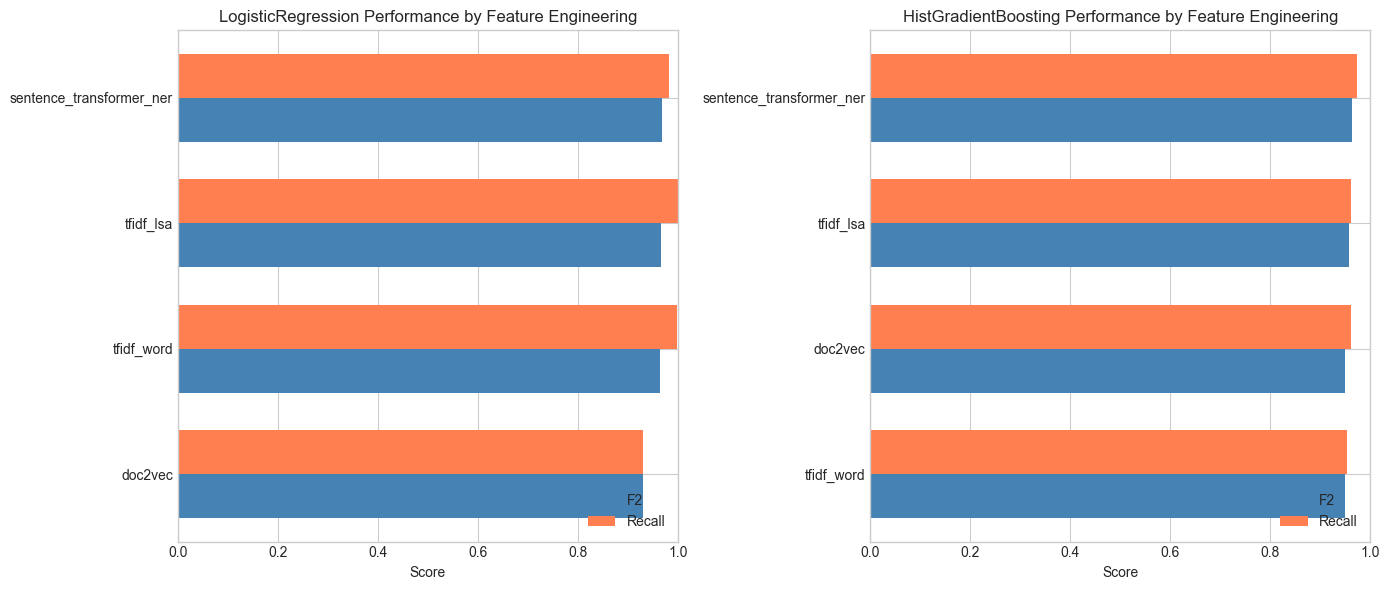

In [19]:
# Visualize comparison - show both classifiers side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, clf_name in enumerate(['LogisticRegression', 'HistGradientBoosting']):
    ax = axes[idx]
    clf_df = fe_df[fe_df['classifier'] == clf_name].set_index('name')
    clf_df = clf_df.sort_values('cv_f2', ascending=True)
    
    x = range(len(clf_df))
    width = 0.35
    
    ax.barh([i - width/2 for i in x], clf_df['cv_f2'], width, label='F2', color='steelblue')
    ax.barh([i + width/2 for i in x], clf_df['cv_recall'], width, label='Recall', color='coral')
    
    ax.set_yticks(list(x))
    ax.set_yticklabels(clf_df.index)
    ax.set_xlabel('Score')
    ax.set_title(f'{clf_name} Performance by Feature Engineering')
    ax.legend(loc='lower right')
    ax.set_xlim(0, 1)

plt.tight_layout()
plt.savefig(MODELS_DIR / 'fe_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 5.1 Feature Transformer Hyperparameter Tuning

Based on the comparison results above, we tune the key hyperparameter for the best-performing feature engineering method. Each method has a primary hyperparameter that affects its feature representation quality.

In [20]:
def tune_feature_transformer(
    method: str,
    base_config: dict,
    param_name: str,
    param_values: list,
    X_train,
    y_train,
    train_source_names: list,
    train_categories: list,
    classifier,
    cv,
    scorer,
) -> pd.DataFrame:
    """Tune a single hyperparameter for the selected feature engineering method.
    
    Args:
        method: Feature engineering method name
        base_config: Base configuration for the transformer
        param_name: Name of the hyperparameter to tune
        param_values: List of values to try
        X_train: Training text features
        y_train: Training labels
        train_source_names: Source names for metadata features
        train_categories: Categories for metadata features
        classifier: Classifier to use for evaluation
        cv: Cross-validation splitter
        scorer: Scoring function
        
    Returns:
        DataFrame with tuning results
    """
    results = []

    for value in param_values:
        print(f"Testing {param_name}={value}...")
        
        # Create config with tuned parameter
        config = base_config.copy()
        config[param_name] = value

        transformer = FPFeatureTransformer(**config, random_state=RANDOM_STATE)
        X_transformed = transformer.fit_transform(
            X_train,
            source_names=train_source_names,
            categories=train_categories
        )

        cv_scores = cross_validate(
            classifier, X_transformed, y_train,
            cv=cv,
            scoring={'f2': scorer, 'recall': 'recall', 'precision': 'precision'},
            return_train_score=False
        )

        results.append({
            param_name: value,
            'cv_f2': cv_scores['test_f2'].mean(),
            'cv_f2_std': cv_scores['test_f2'].std(),
            'cv_recall': cv_scores['test_recall'].mean(),
            'cv_precision': cv_scores['test_precision'].mean(),
        })
        
        print(f"  CV F2: {results[-1]['cv_f2']:.4f} (+/- {results[-1]['cv_f2_std']:.4f})")

    return pd.DataFrame(results)


# Use HistGradientBoosting as the baseline classifier (best performer)
baseline_clf = classifiers['HistGradientBoosting']['model']

# Check if tuning configuration exists for the best method
if best_fe in TUNING_CONFIGS:
    tuning_config = TUNING_CONFIGS[best_fe]
    param_name = tuning_config['param_name']
    param_values = tuning_config['param_values']
    
    print("=" * 70)
    print(f"TUNING {param_name.upper()} FOR {best_fe}")
    print("=" * 70)
    print(f"\nTesting values: {param_values}")
    print(f"Classifier: HistGradientBoostingClassifier (baseline)")
    print(f"CV: {N_FOLDS}-fold stratified\n")
    
    tuning_df = tune_feature_transformer(
        method=best_fe,
        base_config=fe_configs[best_fe],
        param_name=param_name,
        param_values=param_values,
        X_train=X_train,
        y_train=y_train,
        train_source_names=train_source_names,
        train_categories=train_categories,
        classifier=baseline_clf,
        cv=cv,
        scorer=f2_scorer,
    )
    
    print("\n" + "=" * 70)
else:
    print(f"No tuning configuration defined for {best_fe}")
    tuning_df = None

TUNING PROXIMITY_WINDOW_SIZE FOR sentence_transformer_ner

Testing values: [10, 15, 20, 25]
Classifier: HistGradientBoostingClassifier (baseline)
CV: 3-fold stratified

Testing proximity_window_size=10...


  CV F2: 0.9612 (+/- 0.0033)
Testing proximity_window_size=15...


  CV F2: 0.9624 (+/- 0.0020)
Testing proximity_window_size=20...


  CV F2: 0.9613 (+/- 0.0032)
Testing proximity_window_size=25...


  CV F2: 0.9628 (+/- 0.0019)



In [21]:
# Analyze tuning results and select best hyperparameter value
if tuning_df is not None and best_fe in TUNING_CONFIGS:
    param_name = TUNING_CONFIGS[best_fe]['param_name']
    tuning_df_sorted = tuning_df.sort_values('cv_f2', ascending=False)
    
    print(f"{param_name.upper()} TUNING RESULTS")
    print("=" * 70)
    print(tuning_df_sorted.to_string(index=False))
    
    # Find best value
    best_idx = tuning_df['cv_f2'].idxmax()
    optimal_param_value = tuning_df.loc[best_idx, param_name]
    
    # Handle different types (int vs float)
    if isinstance(optimal_param_value, (np.integer, int)):
        optimal_param_value = int(optimal_param_value)
    
    best_tuned_f2 = tuning_df.loc[best_idx, 'cv_f2']
    
    # Get default value from original config if it exists
    default_value = fe_configs[best_fe].get(param_name)
    if default_value is not None:
        default_f2_rows = tuning_df[tuning_df[param_name] == default_value]
        if len(default_f2_rows) > 0:
            default_f2 = default_f2_rows['cv_f2'].values[0]
            improvement = (best_tuned_f2 - default_f2) * 100
        else:
            default_f2 = None
            improvement = None
    else:
        default_f2 = None
        improvement = None
    
    print("\n" + "=" * 70)
    print(f"Optimal {param_name}: {optimal_param_value}")
    print(f"Best CV F2: {best_tuned_f2:.4f}")
    if default_f2 is not None:
        print(f"Default ({default_value}) CV F2: {default_f2:.4f}")
        print(f"Improvement: {improvement:+.2f}%")
    print("=" * 70)
else:
    optimal_param_value = None
    print("No tuning was performed.")

PROXIMITY_WINDOW_SIZE TUNING RESULTS
 proximity_window_size    cv_f2  cv_f2_std  cv_recall  cv_precision
                    25 0.962797   0.001863   0.972868      0.924754
                    15 0.962430   0.002044   0.972868      0.923127
                    20 0.961254   0.003175   0.970930      0.924588
                    10 0.961247   0.003265   0.970930      0.924701

Optimal proximity_window_size: 25
Best CV F2: 0.9628


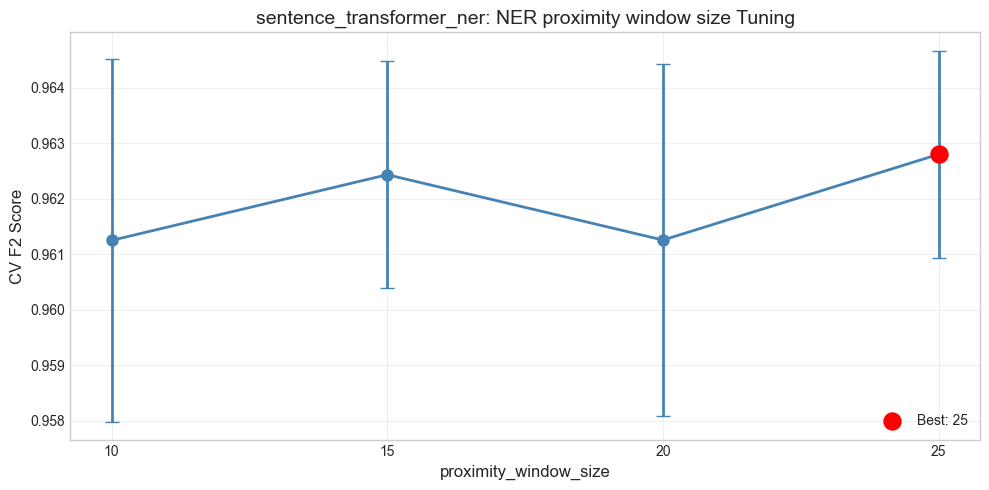

In [22]:
# Visualize hyperparameter tuning results
if tuning_df is not None and best_fe in TUNING_CONFIGS:
    param_name = TUNING_CONFIGS[best_fe]['param_name']
    param_values = TUNING_CONFIGS[best_fe]['param_values']
    description = TUNING_CONFIGS[best_fe]['description']
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Sort by parameter value for plotting
    plot_df = tuning_df.sort_values(param_name)
    
    ax.errorbar(
        plot_df[param_name], 
        plot_df['cv_f2'], 
        yerr=plot_df['cv_f2_std'],
        marker='o', 
        markersize=8,
        capsize=5,
        linewidth=2,
        color='steelblue'
    )
    
    # Highlight best value
    best_tuned_f2 = tuning_df.loc[tuning_df['cv_f2'].idxmax(), 'cv_f2']
    ax.scatter([optimal_param_value], [best_tuned_f2], s=150, c='red', zorder=5, 
               label=f'Best: {optimal_param_value}')
    
    ax.set_xlabel(param_name, fontsize=12)
    ax.set_ylabel('CV F2 Score', fontsize=12)
    ax.set_title(f'{best_fe}: {description} Tuning', fontsize=14)
    ax.set_xticks(param_values)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(MODELS_DIR / f'{best_fe}_tuning.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No tuning visualization - tuning was not performed.")

## 6. Pipeline Export

Create and export the best feature transformer for use in the model selection notebook.

In [23]:
# Create the best transformer with optimal hyperparameters from tuning
print(f"Selected feature engineering approach: {best_fe}")
print(f"Base configuration: {fe_configs[best_fe]}")

# Create final config with optimal hyperparameters
final_config = fe_configs[best_fe].copy()
if best_fe in TUNING_CONFIGS and optimal_param_value is not None:
    param_name = TUNING_CONFIGS[best_fe]['param_name']
    final_config[param_name] = optimal_param_value
    print(f"Optimal {param_name}: {optimal_param_value}")

# Create transformer with best configuration INCLUDING tuned hyperparameters
final_transformer = FPFeatureTransformer(**final_config, random_state=RANDOM_STATE)

# Fit on training data with metadata
X_train_final = final_transformer.fit_transform(
    X_train,
    source_names=train_source_names,
    categories=train_categories
)
print(f"\nFinal feature shape: {X_train_final.shape}")
print(f"Metadata features enabled: {final_transformer.include_metadata_features}")
print(f"Metadata scaler fitted: {final_transformer._metadata_scaler is not None}")

# Verify by transforming validation data
X_val_final = final_transformer.transform(
    X_val,
    source_names=val_source_names,
    categories=val_categories
)
print(f"Validation feature shape: {X_val_final.shape}")

Selected feature engineering approach: sentence_transformer_ner
Base configuration: {'method': 'sentence_transformer_ner', 'sentence_model_name': 'all-MiniLM-L6-v2'}
Optimal proximity_window_size: 25


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 001dcd90-2dcf-4602-803e-9a82bf406871)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/1_Pooling/config.json


Retrying in 1s [Retry 1/5].



Final feature shape: (610, 398)
Metadata features enabled: True
Metadata scaler fitted: True


Validation feature shape: (204, 398)


In [24]:
# Save the fitted transformer
transformer_path = MODELS_DIR / 'fp_feature_transformer.joblib'
joblib.dump(final_transformer, transformer_path)
print(f"Transformer saved to: {transformer_path}")

# Save configuration for reproducibility
config_path = MODELS_DIR / 'fp_feature_config.json'
final_transformer.save_config(config_path)
print(f"Configuration saved to: {config_path}")

# Also save the comparison results
results_path = MODELS_DIR / 'fp_fe_comparison.json'
with open(results_path, 'w') as f:
    json.dump(fe_results, f, indent=2)
print(f"Comparison results saved to: {results_path}")

Transformer saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_transformer.joblib
Configuration saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_config.json
Comparison results saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_fe_comparison.json


## 7. Summary

In [25]:
print("=" * 60)
print("NOTEBOOK SUMMARY")
print("=" * 60)
print(f"\nDataset: {len(df)} articles")
print(f"  - Training: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  - Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"\nClass distribution (training):")
print(f"  - Sportswear: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")
print(f"  - False Positive: {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")
print(f"\nBest Feature Engineering: {best_fe}")
print(f"  - Best Classifier: {best_clf}")
print(f"  - CV F2 Score: {best_row['cv_f2']:.4f}")
print(f"  - Features: {int(best_row['n_features'])}")

# Show tuned hyperparameter if applicable
if best_fe in TUNING_CONFIGS and optimal_param_value is not None:
    param_name = TUNING_CONFIGS[best_fe]['param_name']
    print(f"  - Optimal {param_name}: {optimal_param_value}")

print(f"\nArtifacts saved:")
print(f"  - {MODELS_DIR / 'fp_feature_transformer.joblib'}")
print(f"  - {MODELS_DIR / 'fp_feature_config.json'}")
print(f"  - {MODELS_DIR / 'fp_fe_comparison.json'}")
print(f"\nNext: Run fp2_model_selection_tuning.ipynb for model selection and hyperparameter tuning")
print("=" * 60)

NOTEBOOK SUMMARY

Dataset: 1018 articles
  - Training: 610 (59.9%)
  - Validation: 204 (20.0%)

Class distribution (training):
  - Sportswear: 516 (84.6%)
  - False Positive: 94 (15.4%)

Best Feature Engineering: sentence_transformer_ner
  - Best Classifier: RandomForest
  - CV F2 Score: 0.9697
  - Features: 398
  - Optimal proximity_window_size: 25

Artifacts saved:
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_transformer.joblib
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_config.json
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_fe_comparison.json

Next: Run fp2_model_selection_tuning.ipynb for model selection and hyperparameter tuning
